In [1]:
import numpy as np 
import pandas as pd
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer

# For Building the model
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


[nltk_data] Downloading package stopwords to /Users/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Import and reformat data
df1=pd.read_csv('apple-twitter-sentiment-texts.csv')
df1.head(5)

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [3]:
#Reformat data
df1 = df1.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df1['category'] = df1['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df1.head(5)

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0
1,What Happened To Apple Inc? http://t.co/FJEX...,0.0
2,Thank u @apple I can now compile all of the pi...,1.0
3,The oddly uplifting story of the Apple co-foun...,0.0
4,@apple can i exchange my iphone for a differen...,0.0


In [4]:
#The category column has 3 values:

#0 Indicating it is a Neutral Sentiment
#1 Indicating a Postive Sentiment
#-1 Indicating a Negative Sentiment

In [5]:
df2=pd.read_csv('Twitter_Data.csv')
df2.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
df3=pd.read_csv('Tweets.csv')
df3.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
#Reformat data
df3 = df3.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df3['category'] = df3['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df3 = df3[['category','clean_text']]
df3.head(5)

,category,clean_text
0,0.0,@VirginAmerica What @dhepburn said.
1,1.0,@VirginAmerica plus you've added commercials t...
2,0.0,@VirginAmerica I didn't today... Must mean I n...
3,-1.0,@VirginAmerica it's really aggressive to blast...
4,-1.0,@VirginAmerica and it's a really big bad thing...


In [8]:
#Merge all dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

In [9]:
# Check for missing data
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [10]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [11]:
# dimensionality of the data
df.shape

(179239, 2)

In [12]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,Negative
1,What Happened To Apple Inc? http://t.co/FJEX...,Neutral
2,Thank u @apple I can now compile all of the pi...,Positive
3,The oddly uplifting story of the Apple co-foun...,Neutral
4,@apple can i exchange my iphone for a differen...,Neutral


In [13]:
#EDA stage

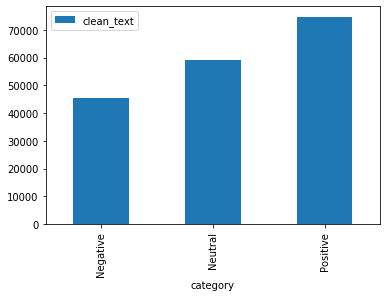

In [14]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

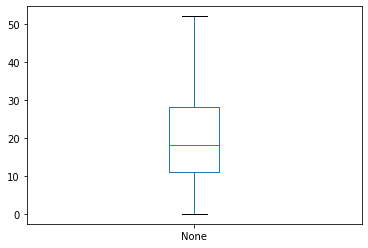

In [15]:
# Calculate tweet lengths
tweet_length = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_length.plot(kind='box')

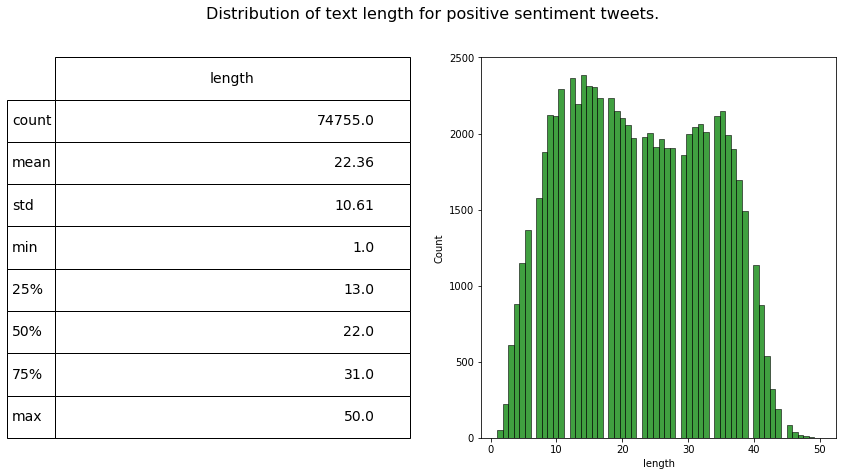

In [16]:
#Plotting the distribution of text length for positive sentiment tweets
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
import seaborn as sns
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

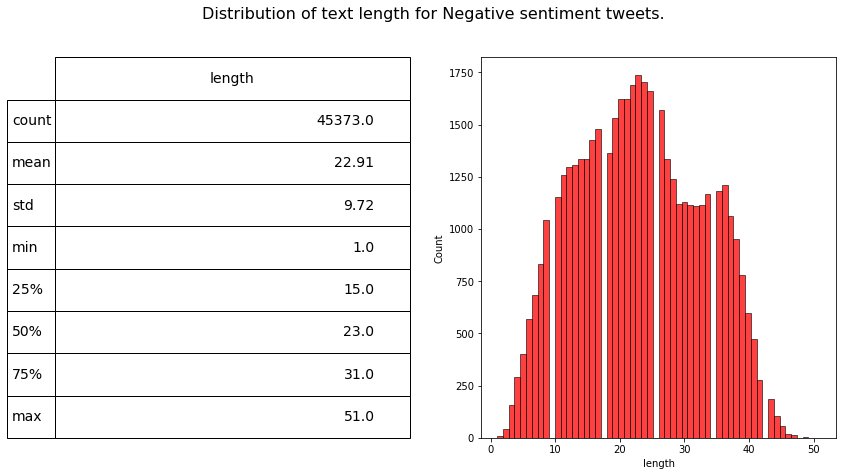

In [17]:
#Plotting the distribution of text length for negative sentiment tweets
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

In [18]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       Wow. Yall needa step it up @Apple RT @heynyla:...  Negative
1       What Happened To Apple Inc?   http://t.co/FJEX...   Neutral
2       Thank u @apple I can now compile all of the pi...  Positive
3       The oddly uplifting story of the Apple co-foun...   Neutral
4       @apple can i exchange my iphone for a differen...   Neutral
...                                                   ...       ...
179245  @AmericanAir thank you we got on a different f...  Positive
179246  @AmericanAir leaving over 20 minutes Late Flig...  Negative
179247  @AmericanAir Please bring American Airlines to...   Neutral
179248  @AmericanAir you have my money, you change my ...  Negative
179249  @AmericanAir we have 8 ppl so we need 2 know h...   Neutral

[179239 rows x 2 columns]>

In [19]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> Wow. Yall needa step it up @Apple RT @heynyla: Music and snapchat at the same damn time. Thank you #Note4

Processed tweet -> ['wow', 'yall', 'needa', 'step', 'appl', 'rt', 'heynyla', 'music', 'snapchat', 'damn', 'time', 'thank', 'note4']


In [20]:
#Data preprocessing
     

In [21]:
# Define a regex pattern to find both @ and hashtags: pattern1
pattern1 = r"([@#]\w+)"
# Use the pattern on the first tweet in the tweets list
hashtags = regexp_tokenize(df['clean_text'][0], pattern1)
print(hashtags)

['@Apple', '@heynyla', '#Note4']


In [22]:
# Use the TweetTokenizer to tokenize all tweets into one list
tknzr = TweetTokenizer()
token_sentences = [tknzr.tokenize(t) for t in df['clean_text']]
print(token_sentences[0])

['Wow', '.', 'Yall', 'needa', 'step', 'it', 'up', '@Apple', 'RT', '@heynyla', ':', 'Music', 'and', 'snapchat', 'at', 'the', 'same', 'damn', 'time', '.', 'Thank', 'you', '#Note4']


In [23]:
# Print the head of df
print(df.head())

# Create a series to store the labels: y
y = df['category']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], y, test_size=0.33, random_state=53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

                                          clean_text  category
0  Wow. Yall needa step it up @Apple RT @heynyla:...  Negative
1  What Happened To Apple Inc?   http://t.co/FJEX...   Neutral
2  Thank u @apple I can now compile all of the pi...  Positive
3  The oddly uplifting story of the Apple co-foun...   Neutral
4  @apple can i exchange my iphone for a differen...   Neutral
['00', '000', '0000', '00000', '000000', '0000000', '00000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001', '0000000001', '0001']


In [24]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])



['00', '000', '0000', '00000', '000000', '0000000', '00000000', '00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001', '0000000001', '0001']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [25]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

   00  000  0000  00000  000000  0000000  00000000  \
0   0    0     0      0       0        0         0   
1   0    0     0      0       0        0         0   
2   0    0     0      0       0        0         0   
3   0    0     0      0       0        0         0   
4   0    0     0      0       0        0         0   

   00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001  \
0                                                  0                                                                                                    
1                                                  0                                                                                                    
2                                                  0                                                                                                    
3                                                  0           

In [26]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['Positive', 'Neutral','Negative'])
print(cm)

0.678675886320986
[[21469  1467  1760]
 [ 7966  9687  1687]
 [ 5260   866  8987]]


In [27]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test,pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['Positive', 'Neutral','Negative'])
print(cm)



0.5873303014421207
[[23472   755   469]
 [12304  6184   852]
 [ 9476   553  5084]]


In [28]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()
    

Alpha:  0.0


/Users/dev/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.6333665826979323

Alpha:  0.1
Score:  0.6501377876210925

Alpha:  0.2
Score:  0.6458097347376963

Alpha:  0.30000000000000004
Score:  0.639030245650814

Alpha:  0.4
Score:  0.6307968012984159

Alpha:  0.5
Score:  0.6228845796209572

Alpha:  0.6000000000000001
Score:  0.6144820707028014

Alpha:  0.7000000000000001
Score:  0.6067220071345246

Alpha:  0.8
Score:  0.5992155404148845

Alpha:  0.9
Score:  0.5931630289607601



In [29]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])



Negative [(-12.162215535749434, '0000'), (-12.162215535749434, '00000'), (-12.162215535749434, '000000'), (-12.162215535749434, '0000000'), (-12.162215535749434, '00000000'), (-12.162215535749434, '0000000001'), (-12.162215535749434, '000114'), (-12.162215535749434, '0005'), (-12.162215535749434, '000kwkajhatka'), (-12.162215535749434, '000s'), (-12.162215535749434, '000waiting'), (-12.162215535749434, '007'), (-12.162215535749434, '007james'), (-12.162215535749434, '00905523223324'), (-12.162215535749434, '00xxxxxxxxx'), (-12.162215535749434, '0100kph'), (-12.162215535749434, '0104also'), (-12.162215535749434, '0118'), (-12.162215535749434, '01201wlyzu'), (-12.162215535749434, '0167560070877')]
Neutral [(-6.884032627543408, 'southwestair'), (-6.821682729009537, 'years'), (-6.764061753195162, 'did'), (-6.749719393970443, 'fake'), (-6.715426033968562, 'money'), (-6.696180518705677, 'dont'), (-6.674624889137649, 'govt'), (-6.635753952748893, 'time'), (-6.478579715357649, 'just'), (-6.471